In [ ]:
!nvidia-smi

Thu Nov 13 06:50:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"사용 가능 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.8.0+cu126
CUDA available: True
사용 가능 메모리: 79.32 GB
CUDA version: 12.6


In [ ]:
#작업 경로 지정
import os
os.chdir('/content/drive/MyDrive/woke-odds')
print(os.getcwd())

/content/drive/MyDrive/woke-odds


In [ ]:
#데이터셋 로드
from datasets import load_dataset
dataset = load_dataset('json', data_files={
    'train': 'ambiguity_train_1110.jsonl',
    'validation': 'ambiguity_valid_1110.jsonl',
    'test': 'ambiguity_test_1110.jsonl'
})
print(f"훈련 데이터: {len(dataset['train'])}개")
print(f"검증 데이터: {len(dataset['validation'])}개")
print(f"평가 데이터: {len(dataset['test'])}개")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

훈련 데이터: 2561개
검증 데이터: 320개
평가 데이터: 321개


In [ ]:
dataset['train'][0]

{'messages': [{'role': 'system',
   'content': "You are an AI system that determines if the question requires clarification and classifies the ambiguity.\n\nTask:\n1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)\n2. Classify the ambiguity:\n   - If question is clear, set category=NONE and subclass=NONE\n   - If question is ambiguous, classify category and subclass\n\nOutput format: category|subclass\n\nCategories:\n- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions\n- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity\n- AO (Aleatoric Output): Questions with missing contextual information causing confusion\n- NONE: Clear questions that don't require clarification\n\nSubclasses:\nFor EM:\n- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts\n- CONT (CONTRADICTION): Query contains self-contradictions\n\nFor LA:\n- LEX (LEXICAL): Query contains terms

####데이터 불균형 해소를 위한 클래스 가중치 적용 훈련

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model
import numpy as np
from collections import Counter

In [ ]:
model_name = "microsoft/Phi-4-mini-reasoning"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    use_cache=False  # Gradient checkpointing과 호환되도록 설정
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# requires_grad 확인
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"✅ {name}: requires_grad=True")
        break
else:
    print("❌ 학습 가능한 파라미터가 없습니다!")

trainable params: 3,670,016 || all params: 3,839,691,776 || trainable%: 0.0956
✅ base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: requires_grad=True


In [ ]:
# 데이터 전처리
def preprocess_function(examples):
    # 'messages' 형식을 text로 변환 (Phi-4 chat template 적용)
    texts = []
    for messages in examples['messages']:
        # Phi-4의 chat template 사용
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(text)

    # 토크나이즈
    model_inputs = tokenizer(
        texts,
        max_length=768,
        truncation=True,
        padding=False  # DataCollator가 처리
    )

    # labels 설정 (CausalLM은 input_ids를 그대로 사용)
    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

In [ ]:
# 토크나이즈 결과 확인
print("=== 토크나이즈 확인 ===")
print(f"Keys: {tokenized_dataset['train'].features}")
print(f"Sample input_ids type: {type(tokenized_dataset['train'][0]['input_ids'])}")
print(f"Sample input_ids length: {len(tokenized_dataset['train'][0]['input_ids'])}")

=== 토크나이즈 확인 ===
Keys: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}
Sample input_ids type: <class 'list'>
Sample input_ids length: 310


In [ ]:
# Custom Data Collator
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class DataCollatorForCausalLM:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        # input_ids의 최대 길이 찾기
        max_length = max(len(f["input_ids"]) for f in features)

        batch = {
            "input_ids": [],
            "attention_mask": [],
            "labels": []
        }

        for feature in features:
            input_ids = feature["input_ids"]
            attention_mask = feature["attention_mask"]
            labels = feature["labels"]

            # 패딩 길이 계산
            padding_length = max_length - len(input_ids)

            # 오른쪽에 패딩 추가
            padded_input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
            padded_attention_mask = attention_mask + [0] * padding_length
            padded_labels = labels + [-100] * padding_length  # -100은 loss 계산에서 무시됨

            batch["input_ids"].append(padded_input_ids)
            batch["attention_mask"].append(padded_attention_mask)
            batch["labels"].append(padded_labels)

        # 리스트를 텐서로 변환
        batch = {k: torch.tensor(v) for k, v in batch.items()}

        return batch

# Data Collator 생성
data_collator = DataCollatorForCausalLM(tokenizer=tokenizer)

In [ ]:
# 테스트: Collator 동작 확인
test_features = [
    tokenized_dataset["train"][i] for i in range(2)
]

print("=== Collator 테스트 ===")
print(f"샘플 1 길이: {len(test_features[0]['input_ids'])}")
print(f"샘플 2 길이: {len(test_features[1]['input_ids'])}")

batch = data_collator(test_features)

print(f"\n배치 shape:")
print(f"input_ids: {batch['input_ids'].shape}")
print(f"attention_mask: {batch['attention_mask'].shape}")
print(f"labels: {batch['labels'].shape}")
print(f"\nlabels에서 -100 개수: {(batch['labels'] == -100).sum().item()}")

=== Collator 테스트 ===
샘플 1 길이: 310
샘플 2 길이: 310

배치 shape:
input_ids: torch.Size([2, 310])
attention_mask: torch.Size([2, 310])
labels: torch.Size([2, 310])

labels에서 -100 개수: 0


In [ ]:
class_weights_v1 = {
    'NONE': 0.6,
    'CONT': 1.0,
    'LEX': 1.0,
    'UNF': 1.2,
    'SEM': 1.5,
    'WHERE': 2.0,
    'WHAT': 1.0,
    'WHEN': 2.5,
    'WHOM': 3.0,
}

In [ ]:
class_weights_v2 = {
    'AO|WHAT': 1.77,
    'AO|WHEN': 1.78,
    'AO|WHERE': 1.78,
    'AO|WHOM': 1.78,
    'EM|CONT': 1.78,
    'EM|UNF': 1.78,
    'LA|LEX': 1.78,
    'LA|SEM': 1.78,
    'NONE|NONE': 0.22
}

In [ ]:
class_weights_v3 = {
    'AO|WHAT': 2.5,
    'AO|WHEN': 2.5,
    'AO|WHERE': 2.5,
    'AO|WHOM': 2.5,
    'EM|CONT': 1.78,
    'EM|UNF': 1.78,
    'LA|LEX': 1.78,
    'LA|SEM': 1.78,
    'NONE|NONE': 0.15
}

In [ ]:
class_weights_v4 = {
    'NONE': 1.0,
    'WHEN': 7.57,
    'WHAT': 7.52,
    'WHOM': 7.57,
    'CONT': 7.57,
    'SEM': 7.57,
    'LEX': 7.57,
    'WHERE': 7.57,
    'UNF': 7.57
}

In [ ]:
class_weights_v5 = {
    'NONE': 1.0,
    'WHEN': 2.83,
    'WHAT': 2.82,
    'WHOM': 2.83,
    'CONT': 2.83,
    'SEM': 2.83,
    'LEX': 2.83,
    'WHERE': 2.83,
    'UNF': 2.83
}

In [ ]:
class_weights_v6 = {
    'NONE': 1.69,
    'WHEN': 3.20,
    'WHAT': 3.19,
    'WHOM': 3.20,
    'CONT': 3.20,
    'SEM': 3.20,
    'LEX': 3.20,
    'WHERE': 3.20,
    'UNF': 3.20
}

In [ ]:
import torch
from torch import nn
from transformers import Trainer
import torch.nn.functional as F

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, tokenizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights  # 서브클래스별 가중치 딕셔너리
        self.tokenizer = tokenizer

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        서브클래스별 가중치가 적용된 loss 계산
        """
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Shift for causal LM
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # 각 샘플별로 loss 계산
        batch_size = shift_logits.size(0)
        total_loss = 0.0
        valid_samples = 0

        for i in range(batch_size):
            sample_logits = shift_logits[i]  # [seq_len, vocab_size]
            sample_labels = shift_labels[i]  # [seq_len]

            # 해당 샘플의 정답 텍스트 디코딩
            label_tokens = sample_labels[sample_labels != -100]
            if len(label_tokens) == 0:
                continue

            try:
                # 정답 텍스트에서 서브클래스 추출 (category|subclass 형태)
                label_text = self.tokenizer.decode(label_tokens, skip_special_tokens=True)

                # category|subclass에서 subclass 추출
                if '|' in label_text:
                    subclass = label_text.split('|')[1].strip()
                else:
                    subclass = 'NONE'

                # 해당 서브클래스의 가중치 가져오기
                weight = self.class_weights.get(subclass, 1.0)

            except:
                weight = 1.0

            # Sample loss 계산
            sample_loss = F.cross_entropy(
                sample_logits,
                sample_labels,
                ignore_index=-100,
                reduction='mean'
            )

            # 가중치 적용
            total_loss += sample_loss * weight
            valid_samples += 1

        # 평균 loss
        loss = total_loss / valid_samples if valid_samples > 0 else total_loss

        return (loss, outputs) if return_outputs else loss

In [ ]:
import torch
from torch import nn
from transformers import Trainer
import torch.nn.functional as F

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, tokenizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights_v3  # category|subclass 레이블별 가중치 딕셔너리
        self.tokenizer = tokenizer

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        category|subclass 레이블별 가중치가 적용된 loss 계산
        """
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Shift for causal LM
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # 각 샘플별로 loss 계산
        batch_size = shift_logits.size(0)
        total_loss = 0.0
        valid_samples = 0

        for i in range(batch_size):
            sample_logits = shift_logits[i]  # [seq_len, vocab_size]
            sample_labels = shift_labels[i]  # [seq_len]

            # 해당 샘플의 정답 텍스트 디코딩
            label_tokens = sample_labels[sample_labels != -100]
            if len(label_tokens) == 0:
                continue

            try:
                # 정답 텍스트에서 전체 레이블 추출 (category|subclass 형태)
                label_text = self.tokenizer.decode(label_tokens, skip_special_tokens=True).strip()

                # 해당 레이블의 가중치 가져오기
                weight = self.class_weights.get(label_text, 1.0)

            except:
                weight = 1.0

            # Sample loss 계산
            sample_loss = F.cross_entropy(
                sample_logits,
                sample_labels,
                ignore_index=-100,
                reduction='mean'
            )

            # 가중치 적용
            total_loss += sample_loss * weight
            valid_samples += 1

        # 평균 loss
        loss = total_loss / valid_samples if valid_samples > 0 else total_loss

        return (loss, outputs) if return_outputs else loss

In [ ]:
# transformers 라이브러리의 로깅 레벨 설정하여 경고 숨기기
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

In [ ]:
training_args = TrainingArguments(
    output_dir='./ambig_improve_v6',  # 이름 변경
    num_train_epochs=3,
    bf16=True,

    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},

    max_grad_norm=1.0,

    dataloader_pin_memory=False,
    torch_empty_cache_steps=50,

    logging_dir='./logs_ambig_improve_v6',  # 이름 변경
    logging_steps=25,

    eval_strategy="steps",
    eval_steps=128,
    save_steps=128,
    save_safetensors=True,

    optim="adamw_8bit",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,

    learning_rate=2e-4,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,

    report_to=["tensorboard"],
)

In [ ]:
#W&B 비활성화
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 41.0 MB/s eta 0:00:00


In [ ]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    class_weights=class_weights_v6,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,  # 3번 연속 개선 없으면 중단
            early_stopping_threshold=0.01  # 최소 개선 임계값
        )
    ]
)

In [ ]:
# 학습 시작
trainer.train()

{'loss': 0.4364, 'grad_norm': 0.7993044853210449, 'learning_rate': 9.79591836734694e-05, 'epoch': 0.15600624024961}
{'loss': 0.4107, 'grad_norm': 0.6805796027183533, 'learning_rate': 0.0002, 'epoch': 0.31201248049922}
{'loss': 0.4093, 'grad_norm': 0.6370334625244141, 'learning_rate': 0.00018847926267281107, 'epoch': 0.46801872074882994}
{'loss': 0.4392, 'grad_norm': 0.7795436382293701, 'learning_rate': 0.00017695852534562213, 'epoch': 0.62402496099844}
{'loss': 0.3972, 'grad_norm': 0.635326623916626, 'learning_rate': 0.0001654377880184332, 'epoch': 0.7800312012480499}
{'eval_loss': 0.1167105883359909, 'eval_runtime': 7.2646, 'eval_samples_per_second': 44.049, 'eval_steps_per_second': 5.506, 'epoch': 0.7987519500780031}
{'loss': 0.3875, 'grad_norm': 0.6451197266578674, 'learning_rate': 0.00015391705069124425, 'epoch': 0.9360374414976599}
{'loss': 0.372, 'grad_norm': 0.7841553092002869, 'learning_rate': 0.0001423963133640553, 'epoch': 1.0873634945397816}
{'loss': 0.4, 'grad_norm': 0.8419

TrainOutput(global_step=483, training_loss=0.3758558368090517, metrics={'train_runtime': 650.5345, 'train_samples_per_second': 11.81, 'train_steps_per_second': 0.742, 'train_loss': 0.3758558368090517, 'epoch': 3.0})

In [ ]:
# 최종 모델 저장
trainer.save_model("./ambig_improve_v6")

### 훈련

In [ ]:
#메모리 정리
import gc
import torch

del trainer
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import torch

In [ ]:
model_name = "microsoft/Phi-4-mini-reasoning"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    use_cache=False  # Gradient checkpointing과 호환되도록 설정
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#LoRA Config 설정
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

#requires_grad 확인
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"✅ {name}: requires_grad=True")
        break
else:
    print("❌ 학습 가능한 파라미터가 없습니다!")

trainable params: 3,670,016 || all params: 3,839,691,776 || trainable%: 0.0956
✅ base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: requires_grad=True


In [ ]:
# 데이터 전처리
def preprocess_function(examples):
    # 'text' 컬럼을 토크나이즈
    model_inputs = tokenizer(
        examples['text'],
        max_length=768,
        truncation=True,
        padding=False  # DataCollator가 처리
    )
    # labels 설정
    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

In [ ]:
#W&B 비활성화
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 42.8 MB/s eta 0:00:00


In [ ]:
#TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results_v2',
    num_train_epochs=3,
    bf16=True,

    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},

    max_grad_norm=1.0,
    weight_decay=0.01,

    dataloader_pin_memory=False,
    torch_empty_cache_steps=50,

    logging_dir='./logs_v2',
    logging_steps= 25,

    eval_strategy="steps",
    eval_steps=128,
    save_steps=128,
    save_safetensors=True,

    optim="adamw_8bit",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,

    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,

    report_to=["tensorboard"],
)

In [ ]:
# Data Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

In [ ]:
# Trainer 생성
from transformers import EarlyStoppingCallback
import torch

# 조합 레이블 순서를 정의합니다. 이 순서는 모델의 최종 출력 레이어 순서와 일치해야 합니다.
# 모델 출력 레이블을 0부터 N-1까지의 정수 인덱스로 매핑해야 합니다.
# 이전 셀(ac2613c8)에서 계산된 class_weights_combined 딕셔너리를 사용합니다.
# 주의: 모델의 실제 출력 순서를 확인하고 이 리스트를 정확하게 매핑해야 합니다.
# 임의의 순서로 설정하며, 실제 모델 출력 순서에 맞춰 수정이 필요합니다.
# 예를 들어, 모델의 LM head가 '0|NONE|NONE', '1|AO|WHAT', ... 순서로 출력한다면
# label_order = ['0|NONE|NONE', '1|AO|WHAT', ...]가 되어야 합니다.
# 현재는 combined_dist의 키 순서대로 가정합니다.
label_order = list(combined_dist.keys()) # combined_dist는 이전 셀에 정의되어 있어야 합니다.

# 클래스 가중치를 텐서로 변환하고 모델 장치로 이동
# label_order에 정의된 순서대로 가중치를 가져옵니다.
class_weights_list = [class_weights_combined[label] for label in label_order]
class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(model.device)

# Trainer 생성 시 compute_metrics는 메모리 문제로 제외하고, class_weights를 loss_fn에 적용
# Hugging Face Trainer는 기본적으로 내부 loss 계산 시 class_weights 인자를 지원하지 않습니다.
# class_weights를 적용하려면 Trainer를 상속하거나, loss 계산 부분을 커스텀해야 합니다.
# 여기서는 간단하게 EarlyStoppingCallback만 사용하여 Trainer를 초기화하고,
# class_weights 적용은 다음 단계에서 Trainer를 커스텀하여 진행하는 것으로 계획합니다.
# (또는 Trainer.__init__에 직접 class_weight 인자를 전달할 수 있는지 문서를 다시 확인)

# 다시 확인해보니 Trainer는 __init__에 class_weight 인자를 직접 받지 않습니다.
# Custom Trainer를 만들거나 compute_metrics를 커스텀하여 loss에 가중치를 적용해야 합니다.
# 여기서는 Custom Trainer 생성을 준비하는 단계로 Trainer 초기화만 진행합니다.
# 클래스 가중치는 추후 Custom Trainer에서 사용될 것입니다.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    processing_class=tokenizer, # Use processing_class instead of tokenizer
    # compute_metrics=compute_metrics # 메모리 문제로 따로 평가
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,  # 3번 연속 개선 없으면 중단
            early_stopping_threshold=0.01  # 최소 개선 임계값
        )
    ]
)

# Note: The class_weights_tensor has been created and is on the correct device,
# but it is not yet actively used in the default Trainer's loss calculation.
# This will require extending the Trainer class or modifying the loss calculation
# within a custom training loop, which is a more advanced step.
# For now, the weights are ready to be used when the custom Trainer is implemented.

/tmp/ipython-input-7782842.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

{'loss': 4.3442, 'grad_norm': 5.864398956298828, 'learning_rate': 3.0769230769230774e-05, 'epoch': 0.1953125}
{'loss': 2.3382, 'grad_norm': 1.7849633693695068, 'learning_rate': 4.855072463768116e-05, 'epoch': 0.390625}
{'loss': 0.8696, 'grad_norm': 1.1515902280807495, 'learning_rate': 4.492753623188406e-05, 'epoch': 0.5859375}
{'loss': 0.2646, 'grad_norm': 0.5233951807022095, 'learning_rate': 4.130434782608696e-05, 'epoch': 0.78125}
{'loss': 0.2115, 'grad_norm': 0.26894497871398926, 'learning_rate': 3.7681159420289856e-05, 'epoch': 0.9765625}
{'eval_loss': 0.19009461998939514, 'eval_runtime': 14.9701, 'eval_samples_per_second': 34.268, 'eval_steps_per_second': 4.342, 'epoch': 1.0}
{'loss': 0.205, 'grad_norm': 0.29757511615753174, 'learning_rate': 3.405797101449276e-05, 'epoch': 1.171875}
{'loss': 0.1952, 'grad_norm': 0.472858190536499, 'learning_rate': 3.0434782608695656e-05, 'epoch': 1.3671875}
{'loss': 0.1677, 'grad_norm': 0.2858000099658966, 'learning_rate': 2.6811594202898553e-05, 

TrainOutput(global_step=384, training_loss=0.6259932539736232, metrics={'train_runtime': 618.5463, 'train_samples_per_second': 9.933, 'train_steps_per_second': 0.621, 'train_loss': 0.6259932539736232, 'epoch': 3.0})

In [ ]:
#베스트 모델 저장
model.save_pretrained('./v2_final_best_model')
tokenizer.save_pretrained('./v2_final_best_model')

('./v2_final_best_model/tokenizer_config.json',
 './v2_final_best_model/special_tokens_map.json',
 './v2_final_best_model/chat_template.jinja',
 './v2_final_best_model/vocab.json',
 './v2_final_best_model/merges.txt',
 './v2_final_best_model/added_tokens.json',
 './v2_final_best_model/tokenizer.json')

###평가

In [ ]:
import os
import torch
import numpy as np
import re
import gc
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    logging as transformers_logging
)

In [ ]:
# 모델 경로 설정 (저장된 모델 경로로 변경하세요)
model_path = "/content/drive/MyDrive/Colab Notebooks/woke-odds/1st_final_best_model"

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 특수 토큰 설정이 필요한 경우 확인
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# GPU 메모리 사용량 최적화
if torch.cuda.is_available():
    model = model.eval()

# 데이터 콜레이터 설정
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#이미 토크나이즈된 후라면, skip
from datasets import load_dataset

# 데이터셋 로드
dataset = load_dataset('json', data_files={
    'train': 'final_CLAMBER_train.jsonl',
    'validation': 'final_CLAMBER_valid.jsonl',
    'test': 'final_CLAMBER_test.jsonl'
})

# 데이터 전처리
tokenized_dataset = dataset.map(
    lambda examples: tokenizer(
        examples['text'],
        max_length=768,
        truncation=True,
        padding=False
    ),
    batched=True,
    remove_columns=dataset["train"].column_names
)

# 레이블 설정
def add_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

tokenized_dataset = tokenized_dataset.map(add_labels, batched=True)

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/641 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/641 [00:00<?, ? examples/s]

In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["validation"] if "validation" in tokenized_dataset else tokenized_dataset["test"]

# 랜덤 샘플 인덱스 선택 (3개 샘플)
num_samples = 3
sample_indices = [int(idx) for idx in np.random.choice(len(eval_dataset), min(num_samples, len(eval_dataset)), replace=False)]

test_results = []

for idx in tqdm(sample_indices, desc="테스트 샘플 처리 중"):
    # 단일 샘플 가져오기
    sample = eval_dataset[idx]

    # 전체 텍스트 디코딩
    full_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)

    # 질문 추출
    question_pattern = r"<\|user\|>Analyze this question: (.*?)<\|end\|>"
    question_match = re.search(question_pattern, full_text)
    question = question_match.group(1) if question_match else "질문을 찾을 수 없음"

    # 정답 레이블 추출
    label_pattern = r"<\|assistant\|>(.*?)<\|end\|>"
    label_match = re.search(label_pattern, full_text)
    expected_label = label_match.group(1) if label_match else "레이블 찾을 수 없음"

    # 시스템 메시지와 사용자 메시지만 추출
    prompt_pattern = r"(<\|system\|>.*?<\|user\|>Analyze this question: .*?<\|end\|>)"
    prompt_match = re.search(prompt_pattern, full_text, re.DOTALL)

    if prompt_match:
        # 원본 프롬프트 + 어시스턴트 시작 태그
        input_prompt = prompt_match.group(1) + "<|assistant|>"

        # 토큰화
        inputs = tokenizer(input_prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            # 생성
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,  # 결정적 생성
            )

        # 생성된 전체 시퀀스
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

        # 입력 이후 생성된 부분만
        input_length = inputs.input_ids.shape[1]
        generated_part = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=False)

        # 예측 레이블 추출
        pred_pattern = r"([01])\|(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
        pred_match = re.search(pred_pattern, generated_part)
        predicted_label = pred_match.group(0) if pred_match else "레이블 찾을 수 없음"
    else:
        input_prompt = "프롬프트를 찾을 수 없음"
        generated_text = "생성 실패"
        generated_part = "생성 실패"
        predicted_label = "레이블 찾을 수 없음"

    test_results.append({
        "sample_idx": idx,
        "question": question,
        "expected_label": expected_label,
        "predicted_label": predicted_label,
        "generated_part": generated_part
    })

    # 메모리 정리
    if 'inputs' in locals():
        del inputs
    if 'outputs' in locals():
        del outputs
    torch.cuda.empty_cache()

# 테스트 결과 출력
for i, sample in enumerate(test_results):
    print(f"===== 샘플 {i+1}/{len(test_results)} =====")
    print(f"질문: {sample['question']}")
    print(f"예상 레이블: {sample['expected_label']}")
    print(f"예측 레이블: {sample['predicted_label']}")
    print("\n생성된 부분:")
    print(sample['generated_part'][:200] + "..." if len(sample['generated_part']) > 200 else sample['generated_part'])
    print("\n" + "="*50 + "\n")

테스트 샘플 처리 중:   0%|          | 0/3 [00:00<?, ?it/s]

===== 샘플 1/3 =====
질문: Can you please divide these fruit and vegetables into red and green colors. Some can be either red or green, so list those as 'both red and green varieties'. Here is the list: cherries, raspberries, lettuce, celery cherries, strawberries, apples, peppers, cabbage, beans, kale, tomatoes, capsicum, raspberries, celery, spinach.
예상 레이블: 1|AO|WHERE
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>


===== 샘플 2/3 =====
질문: When did india won the first cricket world cup?
예상 레이블: 1|AO|WHAT
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>


===== 샘플 3/3 =====
질문: Is Caesalpinia mexicana a photoautotroph trophic guild?
예상 레이블: 1|EM|UNF
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>




In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["validation"] if "validation" in tokenized_dataset else tokenized_dataset["test"]

# 랜덤 샘플 인덱스 선택 (3개 샘플)
num_samples = 3
sample_indices = [int(idx) for idx in np.random.choice(len(eval_dataset), min(num_samples, len(eval_dataset)), replace=False)]

test_results = []

for idx in tqdm(sample_indices, desc="테스트 샘플 처리 중"):
    # 단일 샘플 가져오기
    sample = eval_dataset[idx]

    # 전체 텍스트 디코딩
    full_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)

    # 질문 추출
    question_pattern = r"<\|user\|>Analyze this question: (.*?)<\|end\|>"
    question_match = re.search(question_pattern, full_text)
    question = question_match.group(1) if question_match else "질문을 찾을 수 없음"

    # 정답 레이블 추출
    label_pattern = r"<\|assistant\|>(.*?)<\|end\|>"
    label_match = re.search(label_pattern, full_text)
    expected_label = label_match.group(1) if label_match else "레이블 찾을 수 없음"

    # 시스템 메시지와 사용자 메시지만 추출
    prompt_pattern = r"(<\|system\|>.*?<\|user\|>Analyze this question: .*?<\|end\|>)"
    prompt_match = re.search(prompt_pattern, full_text, re.DOTALL)

    if prompt_match:
        # 원본 프롬프트 + 어시스턴트 시작 태그
        input_prompt = prompt_match.group(1) + "<|assistant|>"

        # 토큰화
        inputs = tokenizer(input_prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            # 생성
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,  # 결정적 생성
            )

        # 생성된 전체 시퀀스
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

        # 입력 이후 생성된 부분만
        input_length = inputs.input_ids.shape[1]
        generated_part = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=False)

        # 예측 레이블 추출
        pred_pattern = r"([01])\|(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
        pred_match = re.search(pred_pattern, generated_part)
        predicted_label = pred_match.group(0) if pred_match else "레이블 찾을 수 없음"
    else:
        input_prompt = "프롬프트를 찾을 수 없음"
        generated_text = "생성 실패"
        generated_part = "생성 실패"
        predicted_label = "레이블 찾을 수 없음"

    test_results.append({
        "sample_idx": idx,
        "question": question,
        "expected_label": expected_label,
        "predicted_label": predicted_label,
        "generated_part": generated_part
    })

    # 메모리 정리
    if 'inputs' in locals():
        del inputs
    if 'outputs' in locals():
        del outputs
    torch.cuda.empty_cache()

# 테스트 결과 출력
for i, sample in enumerate(test_results):
    print(f"===== 샘플 {i+1}/{len(test_results)} =====")
    print(f"질문: {sample['question']}")
    print(f"예상 레이블: {sample['expected_label']}")
    print(f"예측 레이블: {sample['predicted_label']}")
    print("\n생성된 부분:")
    print(sample['generated_part'][:200] + "..." if len(sample['generated_part']) > 200 else sample['generated_part'])
    print("\n" + "="*50 + "\n")

테스트 샘플 처리 중:   0%|          | 0/3 [00:00<?, ?it/s]

===== 샘플 1/3 =====
질문: Can you please divide these fruit and vegetables into red and green colors. Some can be either red or green, so list those as 'both red and green varieties'. Here is the list: cherries, raspberries, lettuce, celery cherries, strawberries, apples, peppers, cabbage, beans, kale, tomatoes, capsicum, raspberries, celery, spinach.
예상 레이블: 1|AO|WHERE
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>


===== 샘플 2/3 =====
질문: When did india won the first cricket world cup?
예상 레이블: 1|AO|WHAT
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>


===== 샘플 3/3 =====
질문: Is Caesalpinia mexicana a photoautotroph trophic guild?
예상 레이블: 1|EM|UNF
예측 레이블: 0|NONE|NONE

생성된 부분:
0|NONE|NONE<|end|><|endoftext|>




모델 평가 시작...


평가 진행 중:   0%|          | 0/65 [00:00<?, ?it/s]


=== 평가 결과 ===
total_samples: 513.0000
valid_samples: 513.0000
invalid_ratio: 0.0000
accuracy_require_clarification: 0.7212
accuracy_category: 0.6940
accuracy_subclass: 0.6199
accuracy_all: 0.6199

총 195 개의 오답 중 일부 샘플:
1. 질문: Give me a list of pizza restaurants in San Francisco
   예상: 1|AO|WHOM
   예측: 0|NONE|NONE

2. 질문: Fifa world cup 2014 young player of the tournament?
   예상: 1|AO|WHAT
   예측: 0|NONE|NONE

3. 질문: 질문을 찾을 수 없음
   예상: 1|LA|SEM
   예측: 0|NONE|NONE

4. 질문: How can I improve my sleep?
   예상: 0|NONE|NONE
   예측: 1|AO|WHOM

5. 질문: Who wrote i heard it on the grapevine?
   예상: 0|NONE|NONE
   예측: 1|AO|WHAT

6. 질문: Who wrote the girl who played with fire?
   예상: 1|AO|WHAT
   예측: 1|AO|WHOM

7. 질문: Provide a list of some Japanese art forms I've not heard of.
   예상: 1|AO|WHOM
   예측: 0|NONE|NONE

8. 질문: When did india won the first cricket world cup?
   예상: 1|AO|WHAT
   예측: 0|NONE|NONE

9. 질문: What was i thinking dierks bentley release date?
   예상: 0|NONE|NONE
   예측: 1|AO|WHOM

10. 질

/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901484822.py:213: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

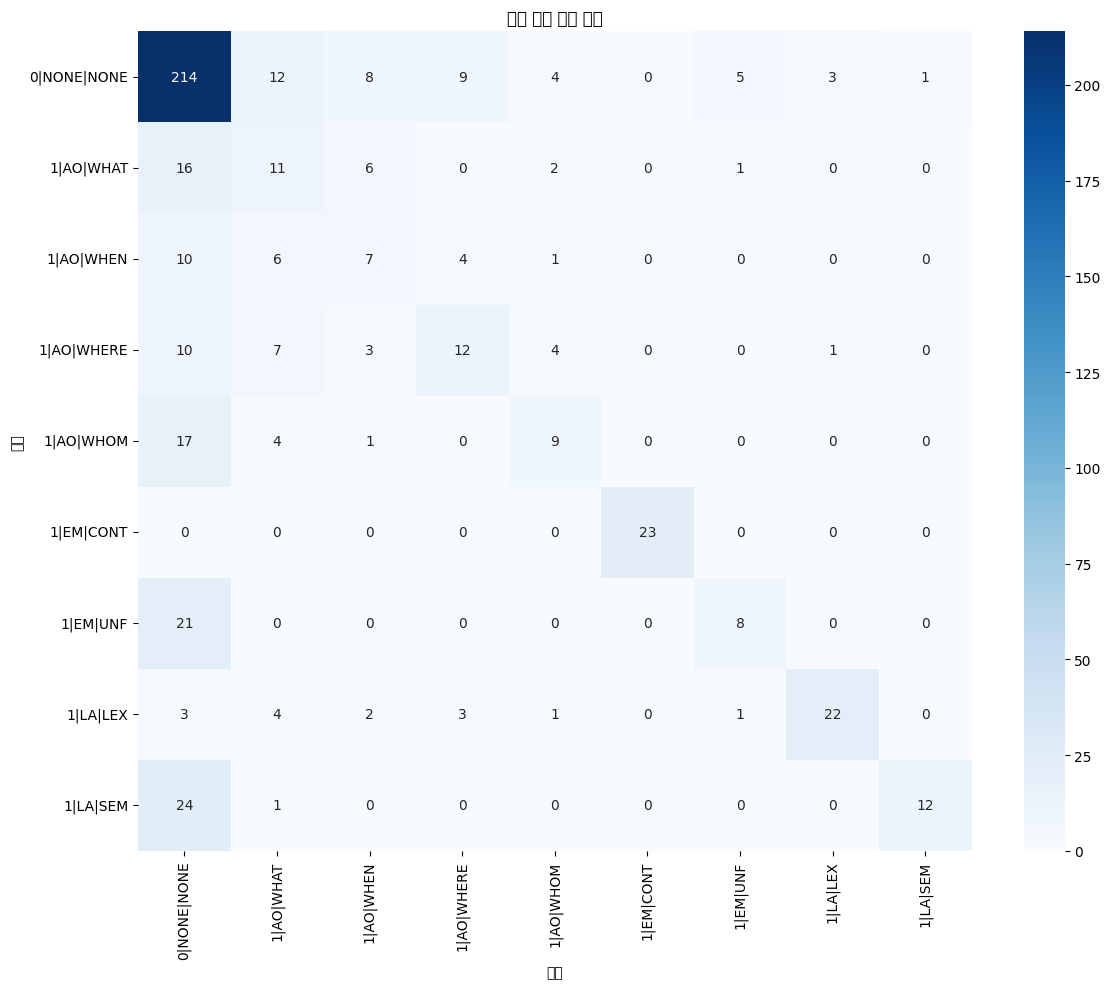

In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["validation"]

# 배치 크기 및 기타 설정
batch_size = 8  # GPU 메모리에 맞게 조정
max_new_tokens = 50  # 응답이 짧으므로 50으로 충분

# 결과 추출 함수
def extract_prediction(generated_text):
    """생성된 텍스트에서 분류 결과를 추출합니다."""
    pattern = r"([01])\|(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
    match = re.search(pattern, generated_text)

    if match:
        return {
            'require_clarification': int(match.group(1)),
            'category': match.group(2),
            'subclass': match.group(3)
        }

    return None

def extract_label(text):
    """입력 텍스트에서 정답 레이블을 추출합니다."""
    pattern = r"([01])\|(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
    match = re.search(pattern, text)

    if match:
        return {
            'require_clarification': int(match.group(1)),
            'category': match.group(2),
            'subclass': match.group(3)
        }

    return None

# DataLoader 생성
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

# 평가 메트릭 초기화
correct_req = 0
correct_cat = 0
correct_sub = 0
correct_all = 0
total_samples = 0
valid_samples = 0
all_results = []

# 평가 실행
print("모델 평가 시작...")
for batch in tqdm(eval_dataloader, desc="평가 진행 중"):
    total_samples += len(batch['input_ids'])

    # 텐서를 장치로 이동
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)

    # 원본 텍스트 디코딩 및 정답 레이블 추출
    original_texts = [tokenizer.decode(ids, skip_special_tokens=False) for ids in batch['input_ids']]
    labels = []

    for text in original_texts:
        label_pattern = r"<\|assistant\|>(.*?)<\|end\|>"
        label_match = re.search(label_pattern, text)

        if label_match:
            label_text = label_match.group(1)
            label = extract_label(label_text)
            labels.append(label)
        else:
            labels.append(None)

    # 입력 프롬프트 생성
    input_prompts = []
    for text in original_texts:
        prompt_pattern = r"(<\|system\|>.*?<\|user\|>.*?<\|end\|>)"
        prompt_match = re.search(prompt_pattern, text, re.DOTALL)

        if prompt_match:
            input_prompt = prompt_match.group(1) + "<|assistant|>"
            input_prompts.append(input_prompt)
        else:
            input_prompts.append(None)

    # 배치 내 각 샘플에 대한 예측 생성
    for i in range(len(input_ids)):
        if input_prompts[i] is None or labels[i] is None:
            continue

        # 토큰화
        prompt_inputs = tokenizer(input_prompts[i], return_tensors="pt").to(model.device)

        # 생성
        with torch.no_grad():
            outputs = model.generate(
                **prompt_inputs,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
            )

        # 생성된 부분만 추출
        input_length = prompt_inputs.input_ids.shape[1]
        generated_part = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=False)

        # 예측 레이블 추출
        pred = extract_prediction(generated_part)

        # 정답 레이블과 예측 레이블 비교
        if pred:
            valid_samples += 1

            # 질문 추출
            question_pattern = r"<\|user\|>Analyze this question: (.*?)<\|end\|>"
            question_match = re.search(question_pattern, original_texts[i])
            question = question_match.group(1) if question_match else "질문을 찾을 수 없음"

            # 결과 저장
            result = {
                "question": question,
                "expected": f"{labels[i]['require_clarification']}|{labels[i]['category']}|{labels[i]['subclass']}",
                "predicted": f"{pred['require_clarification']}|{pred['category']}|{pred['subclass']}",
                "is_correct": False
            }

            # 정확도 계산
            if pred['require_clarification'] == labels[i]['require_clarification']:
                correct_req += 1

            if pred['category'] == labels[i]['category']:
                correct_cat += 1

            if pred['subclass'] == labels[i]['subclass']:
                correct_sub += 1

            if (pred['require_clarification'] == labels[i]['require_clarification'] and
                pred['category'] == labels[i]['category'] and
                pred['subclass'] == labels[i]['subclass']):
                correct_all += 1
                result["is_correct"] = True

            all_results.append(result)

        # 메모리 정리
        del prompt_inputs, outputs

    # 배치 메모리 정리
    del input_ids, attention_mask
    torch.cuda.empty_cache()
    gc.collect()

# 메트릭 계산
metrics = {
    'total_samples': total_samples,
    'valid_samples': valid_samples,
    'invalid_ratio': (total_samples - valid_samples) / total_samples if total_samples > 0 else 0,
    'accuracy_require_clarification': correct_req / valid_samples if valid_samples > 0 else 0,
    'accuracy_category': correct_cat / valid_samples if valid_samples > 0 else 0,
    'accuracy_subclass': correct_sub / valid_samples if valid_samples > 0 else 0,
    'accuracy_all': correct_all / valid_samples if valid_samples > 0 else 0,
}

# 메트릭 출력
print("\n=== 평가 결과 ===")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# 오류 분석
incorrect_predictions = [r for r in all_results if not r["is_correct"]]
print(f"\n총 {len(incorrect_predictions)} 개의 오답 중 일부 샘플:")
for i, result in enumerate(incorrect_predictions[:10]):  # 처음 10개만 출력
    print(f"{i+1}. 질문: {result['question']}")
    print(f"   예상: {result['expected']}")
    print(f"   예측: {result['predicted']}")
    print()

# 혼동 행렬 (Confusion Matrix) 생성 및 시각화 (선택 사항)
try:
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # 클래스 레이블 추출
    y_true = [r["expected"] for r in all_results]
    y_pred = [r["predicted"] for r in all_results]

    # 고유 레이블 (최대 20개까지만 표시)
    unique_labels = sorted(list(set(y_true + y_pred)))
    if len(unique_labels) > 20:
        # 가장 빈번한 레이블 20개만 선택
        from collections import Counter
        label_counts = Counter(y_true + y_pred)
        unique_labels = [label for label, _ in label_counts.most_common(20)]

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # 데이터프레임으로 변환
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

    # 혼동 행렬 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('예측')
    plt.ylabel('실제')
    plt.title('분류 결과 혼동 행렬')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("시각화 라이브러리가 설치되어 있지 않아 혼동 행렬을 표시할 수 없습니다.")

### 파라미터 설정을 위한 실험

In [ ]:
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np

# 모델 이름
model_name = "microsoft/Phi-4-mini-reasoning"

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 각 split의 토큰 길이 계산
def calculate_lengths(split_data, split_name):
    lengths = [len(tokenizer.encode(item['text'])) for item in tqdm(split_data, desc=f"{split_name}")]
    print(f"\n{split_name} 데이터:")
    print(f"  최대 길이: {max(lengths)}")
    print(f"  평균 길이: {np.mean(lengths):.1f}")
    print(f"  중간값: {np.median(lengths):.1f}")
    print(f"  95 백분위수: {np.percentile(lengths, 95):.1f}")
    return max(lengths)

max_length_train = calculate_lengths(dataset['train'], "Train")
max_length_validation = calculate_lengths(dataset['validation'], "Validation")
max_length_test = calculate_lengths(dataset['test'], "Test")

Train: 100%|██████████| 2048/2048 [00:10<00:00, 188.65it/s]



Train 데이터:
  최대 길이: 1904
  평균 길이: 497.2
  중간값: 471.0
  95 백분위수: 649.0


Validation: 100%|██████████| 513/513 [00:02<00:00, 213.92it/s]



Validation 데이터:
  최대 길이: 675
  평균 길이: 490.3
  중간값: 471.0
  95 백분위수: 621.8


Test: 100%|██████████| 641/641 [00:02<00:00, 305.29it/s]


Test 데이터:
  최대 길이: 998
  평균 길이: 495.3
  중간값: 471.0
  95 백분위수: 645.0


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc

# 모델 이름
model_name = "microsoft/Phi-4-mini-reasoning"

# GPU 메모리 측정 함수
def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**3  # GB 단위
    return 0

# 메모리 초기화 함수
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

print("=" * 60)
print("Gradient Checkpointing 메모리 테스트 (ON만)")
print("=" * 60)

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# 더미 데이터 준비 (max_seq_length=768, batch_size=8)
dummy_texts = ["This is a test sentence for memory profiling. " * 50] * 8
inputs = tokenizer(dummy_texts, return_tensors="pt", padding=True,
                   truncation=True, max_length=768)

clear_memory()

# Gradient Checkpointing 활성화 테스트
print("\n[테스트] Gradient Checkpointing ON + 배치 크기 8")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=False  # Gradient checkpointing과 호환되도록 설정
)

# Gradient Checkpointing 활성화
model.gradient_checkpointing_enable()

# 입력을 모델과 같은 디바이스로 이동
inputs = {k: v.to(model.device) for k, v in inputs.items()}

memory_before = get_gpu_memory()
print(f"   모델 로드 후 메모리: {memory_before:.2f} GB")

outputs = None
loss = None

try:
    # Forward + Backward pass
    model.train()
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    loss.backward()

    memory_after = get_gpu_memory()
    peak_memory = torch.cuda.max_memory_allocated() / 1024**3

    print(f"   학습 중 메모리: {memory_after:.2f} GB")
    print(f"   최대 메모리 사용량: {peak_memory:.2f} GB")
    print("\n✅ 성공: Gradient Checkpointing으로 배치 크기 8 학습 가능!")

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"\n❌ OOM 발생: 배치 크기 8은 여전히 부족")
        print("   → 배치 크기를 4로 줄이고 gradient_accumulation_steps=2 사용 권장")
    else:
        print(f"에러: {e}")

# 메모리 정리
if outputs is not None:
    del outputs
if loss is not None:
    del loss
del model
clear_memory()

print("\n" + "=" * 60)
print("결론")
print("=" * 60)
print("✅ Gradient Checkpointing은 반드시 활성화해야 합니다!")

Gradient Checkpointing 메모리 테스트 (ON만)

[테스트] Gradient Checkpointing ON + 배치 크기 8


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   모델 로드 후 메모리: 7.15 GB

❌ OOM 발생: 배치 크기 8은 여전히 부족
   → 배치 크기를 4로 줄이고 gradient_accumulation_steps=2 사용 권장

결론
✅ Gradient Checkpointing은 반드시 활성화해야 합니다!


In [ ]:
# LoRA 파라미터 확인
print("\n=== LoRA 파라미터 확인 ===")
for name, param in model.named_parameters():
    if "lora" in name.lower():
        print(f"{name}: requires_grad={param.requires_grad}")


=== LoRA 파라미터 확인 ===
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: requires_grad=True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: requires_grad=True
base_model.model.model.layers.0.self_attn.qkv_proj.lora_A.default.weight: requires_grad=True
base_model.model.model.layers.0.self_attn.qkv_proj.lora_B.default.weight: requires_grad=True
base_model.model.model.layers.1.self_attn.o_proj.lora_A.default.weight: requires_grad=True
base_model.model.model.layers.1.self_attn.o_proj.lora_B.default.weight: requires_grad=True
base_model.model.model.layers.1.self_attn.qkv_proj.lora_A.default.weight: requires_grad=True
base_model.model.model.layers.1.self_attn.qkv_proj.lora_B.default.weight: requires_grad=True
base_model.model.model.layers.2.self_attn.o_proj.lora_A.default.weight: requires_grad=True
base_model.model.model.layers.2.self_attn.o_proj.lora_B.default.weight: requires_grad=True
base_model.model.model.layers.2.self_attn.qkv_proj.lora_A.de